RoBERTa for Semantic Evaluation
USe of GPU capabilitiwes is strongly advised. https://developer.nvidia.com/cuda-downloads?target_os=Windows&target_arch=x86_64&target_version=10

Tested on Python 3.8.10

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")



Mounted at /content/drive/


In [ ]:
import os
root = '/content/drive/My Drive/stud/nlp/isits_ft/'
semeval2_root = '/content/drive/My Drive/stud/nlp/semeval2/'


In [ ]:
!pip3 install transformers==4.25.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.2 MB/s eta 0:00:00


In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import seaborn as sns
import transformers
import pandas as pd
import seaborn as sns
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from ipywidgets import IntProgress
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
import time

Konfugurujemy czy trenować model dla scorów czy dla typów.

In [ ]:
# Output value is based on alignment SCORE or TYPE
is_score_based = True
if (is_score_based):
    num_outputs = 5
else:
    num_outputs = 6

Proba ze zbiorem semieval2

In [ ]:
df_train_s2 = pd.read_csv(semeval2_root+'train.csv', header= 0)
df_test_s2 = pd.read_csv(semeval2_root+'test.csv', header= 0)
df = pd.concat([df_train_s2, df_test_s2])
df = df.sample(frac=1.0)

def preprocess_semeval(semeval_df, is_score_based = False):
  types_map = {'EQUI':0, 'SIMI':1, 'SPE1':2, 'SPE2':3, 'REL':4, 'OPPO':5}

  semeval_df['text'] = semeval_df['x1'] + " . " + semeval_df['x2']
  if is_score_based:
      semeval_df['target'] = semeval_df['y_score'] - 1
      
  else:
      semeval_df['target'] = semeval_df['y_type'] - 1
  semeval_df = semeval_df.drop(['y_type'], axis=1)
  semeval_df = semeval_df.drop(['y_score'], axis=1)
  semeval_df = semeval_df.drop(['x1'], axis=1)
  semeval_df = semeval_df.drop(['x2'], axis=1)
  return semeval_df

df = preprocess_semeval(df, is_score_based=is_score_based)

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df, test_size=0.2)

In [ ]:
df_valid.shape

(1424, 2)

In [ ]:
# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
class Data(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [ ]:
MAX_LEN = 256

train_data = df_train.reset_index(drop=True)
valid_data = df_valid.reset_index(drop=True)
#test_data = df_test.reset_index(drop=True)

print("TRAIN Dataset: {}".format(train_data.shape))
print("VALID Dataset: {}".format(valid_data.shape))
#print("TEST Dataset: {}".format(test_data.shape))

training_set = Data(train_data, tokenizer, MAX_LEN)
valid_set = Data(valid_data, tokenizer, MAX_LEN)
#testing_set = Data(test_data, tokenizer, MAX_LEN)

TRAIN Dataset: (5695, 2)
VALID Dataset: (1424, 2)


In [ ]:
class_value_counts = pd.DataFrame(train_data['target']).value_counts(sort=False)
    # odwrotne wagowanie klas
weights = ((1/class_value_counts.values) / np.sum(1/class_value_counts.values ))
print(weights)
class_weights = torch.FloatTensor(weights).cuda()

[0.18079818 0.08414069 0.05912589 0.65629738 0.01963786]


In [ ]:
def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, path)
    

def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self, roberta_path = None, roberta_model = None):
        super(RobertaClass, self).__init__()
        if roberta_path:
          self.l1 = torch.load(roberta_path)
        if roberta_model:
          self.l1 = roberta_model
        else:
          self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, num_outputs)

    def save_roberta(self, path):
        torch.save(self.l1, path)

    def save_model(self, path):
        torch.save(self, path)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
loss_fun = torch.nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
def transfer_learning(model, 
             optimizer, 
             training_loader, 
             valid_loader, 
             scheduler = None,
             valid_period = 0,
             num_epochs = 5):
    
    # #Pretrain linear layers, do not train bert
    for param in model.l1.parameters():
        param.requires_grad = False
    
    model.train()
    valid_period = len(training_loader)
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    # Train loop
    for epoch in range(num_epochs):
        for _,data in tqdm(enumerate(training_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)

            outputs = model(ids, mask, token_type_ids)
            
            loss = loss_fun(outputs, targets)
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                valid_loss = 0.0
                with torch.no_grad():
                                        
                    for _,vdata in tqdm(enumerate(valid_loader, 0)):
                        vids = vdata['ids'].to(device, dtype = torch.long)
                        vmask = vdata['mask'].to(device, dtype = torch.long)
                        vtoken_type_ids = vdata['token_type_ids'].to(device, dtype = torch.long)
                        vtargets = vdata['targets'].to(device, dtype = torch.long)

                        voutputs = model(vids, vmask, vtoken_type_ids)
                        
              
                        vloss = loss_fun(voutputs, vtargets)
                        
                        valid_loss += vloss.item()

                # Store train and validation loss history
                train_loss = train_loss / len(training_loader)
                valid_loss = valid_loss / len(valid_loader)

                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)
                
                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(training_loader),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    print("Saving roberta model {} ...".format(valid_loss))
                    model.save_model(path = root +'/'+experiment_name+'_roberta_classifier')
                    print('Model saved')
                    #model.save_roberta(path = root + '/'+experiment_name+'_roberta_classifier')
                    
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()

                


        save_metrics(root + '/'+experiment_name+'_metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    # #Set bert parameters back to trainable
    for param in model.l1.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

In [ ]:
train_params = {'batch_size': 16,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': 16,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
valid_loader = DataLoader(valid_set, **test_params)

In [ ]:
models_root = '/content/drive/My Drive/stud/nlp/'

roberta_path = models_root+'/roberta_base_class_weights'
#roberta1 = torch.load(models_root+'/roberta_base_class_weights')
##model1 = RobertaClass(roberta_path = roberta_path)
#model1 = model1.to(device)

roberta_unsupervised = RobertaModel.from_pretrained(models_root+'roberta-unsupervised/')
model2 = RobertaClass(roberta_model = roberta_unsupervised)
model2 = model2.to(device)

experiment_name = "RobertaPreatrainedUnsupervisedScores"


#baseline = RobertaClass()
#baseline = baseline.to(device)

model = model2

Fine tuning

In [ ]:

# Fine tune 
NUM_EPOCHS = 12
steps_per_epoch = len(training_loader)



LR = 1e-5

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.0001},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
        ]  
    
optimizer = AdamW(model.parameters(),  lr=LR)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)



transfer_learning(model=model,
         training_loader=training_loader,
         valid_loader=valid_loader,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_len

Epoch [1/12], global step [354/4248], PT Loss: 1.7884, Val Loss: 1.7526
Saving roberta model 1.7525849261980377 ...


354it [01:43,  3.41it/s]


Model saved


353it [01:25,  4.11it/s]
0it [00:00, ?it/s]
1it [00:00,  4.73it/s]
2it [00:00,  4.67it/s]
3it [00:00,  4.67it/s]
4it [00:00,  4.67it/s]
5it [00:01,  4.66it/s]
6it [00:01,  4.65it/s]
7it [00:01,  4.63it/s]
8it [00:01,  4.64it/s]
9it [00:01,  4.67it/s]
10it [00:02,  4.65it/s]
11it [00:02,  4.65it/s]
12it [00:02,  4.62it/s]
13it [00:02,  4.62it/s]
14it [00:03,  4.63it/s]
15it [00:03,  4.62it/s]
16it [00:03,  4.55it/s]
17it [00:03,  4.51it/s]
18it [00:03,  4.56it/s]
19it [00:04,  4.56it/s]
20it [00:04,  4.58it/s]
21it [00:04,  4.60it/s]
22it [00:04,  4.57it/s]
23it [00:04,  4.58it/s]
24it [00:05,  4.59it/s]
25it [00:05,  4.58it/s]
26it [00:05,  4.60it/s]
27it [00:05,  4.58it/s]
28it [00:06,  4.59it/s]
29it [00:06,  4.59it/s]
30it [00:06,  4.58it/s]
31it [00:06,  4.60it/s]
32it [00:06,  4.61it/s]
33it [00:07,  4.62it/s]
34it [00:07,  4.62it/s]
35it [00:07,  4.62it/s]
36it [00:07,  4.61it/s]
37it [00:08,  4.61it/s]
38it [00:08,  4.63it/s]
39it [00:08,  4.62it/s]
40it [00:08,  4.64it/s]
41it 

Epoch [2/12], global step [708/4248], PT Loss: 1.7466, Val Loss: 1.6770
Saving roberta model 1.6769989648561798 ...


354it [01:46,  3.31it/s]


Model saved


353it [01:28,  3.99it/s]
0it [00:00, ?it/s]
1it [00:00,  4.70it/s]
2it [00:00,  4.65it/s]
3it [00:00,  4.64it/s]
4it [00:00,  4.63it/s]
5it [00:01,  4.57it/s]
6it [00:01,  4.57it/s]
7it [00:01,  4.58it/s]
8it [00:01,  4.59it/s]
9it [00:01,  4.59it/s]
10it [00:02,  4.59it/s]
11it [00:02,  4.59it/s]
12it [00:02,  4.60it/s]
13it [00:02,  4.61it/s]
14it [00:03,  4.59it/s]
15it [00:03,  4.58it/s]
16it [00:03,  4.58it/s]
17it [00:03,  4.59it/s]
18it [00:03,  4.60it/s]
19it [00:04,  4.60it/s]
20it [00:04,  4.59it/s]
21it [00:04,  4.60it/s]
22it [00:04,  4.62it/s]
23it [00:05,  4.61it/s]
24it [00:05,  4.59it/s]
25it [00:05,  4.58it/s]
26it [00:05,  4.59it/s]
27it [00:05,  4.59it/s]
28it [00:06,  4.59it/s]
29it [00:06,  4.60it/s]
30it [00:06,  4.61it/s]
31it [00:06,  4.59it/s]
32it [00:06,  4.56it/s]
33it [00:07,  4.53it/s]
34it [00:07,  4.53it/s]
35it [00:07,  4.54it/s]
36it [00:07,  4.57it/s]
37it [00:08,  4.55it/s]
38it [00:08,  4.55it/s]
39it [00:08,  4.56it/s]
40it [00:08,  4.58it/s]
41it 

Epoch [3/12], global step [1062/4248], PT Loss: 1.6661, Val Loss: 1.5768
Saving roberta model 1.5767579025097107 ...


354it [01:54,  3.10it/s]


Model saved


353it [01:28,  4.02it/s]
0it [00:00, ?it/s]
1it [00:00,  4.69it/s]
2it [00:00,  4.67it/s]
3it [00:00,  4.66it/s]
4it [00:00,  4.66it/s]
5it [00:01,  4.60it/s]
6it [00:01,  4.57it/s]
7it [00:01,  4.61it/s]
8it [00:01,  4.63it/s]
9it [00:01,  4.62it/s]
10it [00:02,  4.61it/s]
11it [00:02,  4.63it/s]
12it [00:02,  4.64it/s]
13it [00:02,  4.64it/s]
14it [00:03,  4.61it/s]
15it [00:03,  4.61it/s]
16it [00:03,  4.62it/s]
17it [00:03,  4.63it/s]
18it [00:03,  4.62it/s]
19it [00:04,  4.61it/s]
20it [00:04,  4.61it/s]
21it [00:04,  4.61it/s]
22it [00:04,  4.60it/s]
23it [00:04,  4.62it/s]
24it [00:05,  4.60it/s]
25it [00:05,  4.60it/s]
26it [00:05,  4.61it/s]
27it [00:05,  4.60it/s]
28it [00:06,  4.59it/s]
29it [00:06,  4.58it/s]
30it [00:06,  4.59it/s]
31it [00:06,  4.59it/s]
32it [00:06,  4.59it/s]
33it [00:07,  4.59it/s]
34it [00:07,  4.59it/s]
35it [00:07,  4.58it/s]
36it [00:07,  4.58it/s]
37it [00:08,  4.57it/s]
38it [00:08,  4.58it/s]
39it [00:08,  4.60it/s]
40it [00:08,  4.57it/s]
41it 

Epoch [4/12], global step [1416/4248], PT Loss: 1.5985, Val Loss: 1.5309
Saving roberta model 1.5308551868695892 ...


354it [01:49,  3.22it/s]


Model saved


353it [01:28,  4.01it/s]
0it [00:00, ?it/s]
1it [00:00,  4.77it/s]
2it [00:00,  4.70it/s]
3it [00:00,  4.69it/s]
4it [00:00,  4.67it/s]
5it [00:01,  4.60it/s]
6it [00:01,  4.61it/s]
7it [00:01,  4.62it/s]
8it [00:01,  4.63it/s]
9it [00:01,  4.61it/s]
10it [00:02,  4.61it/s]
11it [00:02,  4.61it/s]
12it [00:02,  4.62it/s]
13it [00:02,  4.61it/s]
14it [00:03,  4.59it/s]
15it [00:03,  4.59it/s]
16it [00:03,  4.59it/s]
17it [00:03,  4.60it/s]
18it [00:03,  4.60it/s]
19it [00:04,  4.61it/s]
20it [00:04,  4.63it/s]
21it [00:04,  4.63it/s]
22it [00:04,  4.64it/s]
23it [00:04,  4.61it/s]
24it [00:05,  4.60it/s]
25it [00:05,  4.61it/s]
26it [00:05,  4.62it/s]
27it [00:05,  4.61it/s]
28it [00:06,  4.61it/s]
29it [00:06,  4.62it/s]
30it [00:06,  4.63it/s]
31it [00:06,  4.63it/s]
32it [00:06,  4.61it/s]
33it [00:07,  4.62it/s]
34it [00:07,  4.61it/s]
35it [00:07,  4.59it/s]
36it [00:07,  4.60it/s]
37it [00:08,  4.57it/s]
38it [00:08,  4.58it/s]
39it [00:08,  4.59it/s]
40it [00:08,  4.59it/s]
41it 

Epoch [5/12], global step [1770/4248], PT Loss: 1.5613, Val Loss: 1.4686
Saving roberta model 1.4685980376232877 ...


354it [01:50,  3.21it/s]


Model saved


353it [01:28,  4.01it/s]
0it [00:00, ?it/s]
1it [00:00,  4.81it/s]
2it [00:00,  4.69it/s]
3it [00:00,  4.63it/s]
4it [00:00,  4.65it/s]
5it [00:01,  4.61it/s]
6it [00:01,  4.61it/s]
7it [00:01,  4.60it/s]
8it [00:01,  4.61it/s]
9it [00:01,  4.60it/s]
10it [00:02,  4.60it/s]
11it [00:02,  4.60it/s]
12it [00:02,  4.61it/s]
13it [00:02,  4.58it/s]
14it [00:03,  4.58it/s]
15it [00:03,  4.59it/s]
16it [00:03,  4.60it/s]
17it [00:03,  4.61it/s]
18it [00:03,  4.61it/s]
19it [00:04,  4.61it/s]
20it [00:04,  4.62it/s]
21it [00:04,  4.60it/s]
22it [00:04,  4.60it/s]
23it [00:04,  4.60it/s]
24it [00:05,  4.60it/s]
25it [00:05,  4.61it/s]
26it [00:05,  4.61it/s]
27it [00:05,  4.62it/s]
28it [00:06,  4.61it/s]
29it [00:06,  4.58it/s]
30it [00:06,  4.59it/s]
31it [00:06,  4.60it/s]
32it [00:06,  4.61it/s]
33it [00:07,  4.60it/s]
34it [00:07,  4.61it/s]
35it [00:07,  4.59it/s]
36it [00:07,  4.58it/s]
37it [00:08,  4.57it/s]
38it [00:08,  4.56it/s]
39it [00:08,  4.55it/s]
40it [00:08,  4.56it/s]
41it 

Epoch [6/12], global step [2124/4248], PT Loss: 1.5396, Val Loss: 1.4198
Saving roberta model 1.4198074863198098 ...


354it [01:50,  3.22it/s]


Model saved


353it [01:28,  4.01it/s]
0it [00:00, ?it/s]
1it [00:00,  4.79it/s]
2it [00:00,  4.71it/s]
3it [00:00,  4.69it/s]
4it [00:00,  4.67it/s]
5it [00:01,  4.62it/s]
6it [00:01,  4.61it/s]
7it [00:01,  4.63it/s]
8it [00:01,  4.60it/s]
9it [00:01,  4.60it/s]
10it [00:02,  4.59it/s]
11it [00:02,  4.61it/s]
12it [00:02,  4.61it/s]
13it [00:02,  4.61it/s]
14it [00:03,  4.60it/s]
15it [00:03,  4.59it/s]
16it [00:03,  4.57it/s]
17it [00:03,  4.58it/s]
18it [00:03,  4.57it/s]
19it [00:04,  4.57it/s]
20it [00:04,  4.60it/s]
21it [00:04,  4.60it/s]
22it [00:04,  4.60it/s]
23it [00:04,  4.60it/s]
24it [00:05,  4.61it/s]
25it [00:05,  4.60it/s]
26it [00:05,  4.58it/s]
27it [00:05,  4.56it/s]
28it [00:06,  4.57it/s]
29it [00:06,  4.55it/s]
30it [00:06,  4.59it/s]
31it [00:06,  4.58it/s]
32it [00:06,  4.58it/s]
33it [00:07,  4.58it/s]
34it [00:07,  4.59it/s]
35it [00:07,  4.59it/s]
36it [00:07,  4.59it/s]
37it [00:08,  4.59it/s]
38it [00:08,  4.59it/s]
39it [00:08,  4.59it/s]
40it [00:08,  4.60it/s]
41it 

Epoch [7/12], global step [2478/4248], PT Loss: 1.4997, Val Loss: 1.4188
Saving roberta model 1.4188419520185236 ...


354it [01:49,  3.23it/s]


Model saved


353it [01:28,  4.00it/s]
0it [00:00, ?it/s]
1it [00:00,  4.75it/s]
2it [00:00,  4.70it/s]
3it [00:00,  4.70it/s]
4it [00:00,  4.65it/s]
5it [00:01,  4.59it/s]
6it [00:01,  4.60it/s]
7it [00:01,  4.60it/s]
8it [00:01,  4.59it/s]
9it [00:01,  4.58it/s]
10it [00:02,  4.58it/s]
11it [00:02,  4.61it/s]
12it [00:02,  4.61it/s]
13it [00:02,  4.60it/s]
14it [00:03,  4.58it/s]
15it [00:03,  4.58it/s]
16it [00:03,  4.60it/s]
17it [00:03,  4.61it/s]
18it [00:03,  4.58it/s]
19it [00:04,  4.58it/s]
20it [00:04,  4.59it/s]
21it [00:04,  4.59it/s]
22it [00:04,  4.60it/s]
23it [00:04,  4.59it/s]
24it [00:05,  4.58it/s]
25it [00:05,  4.58it/s]
26it [00:05,  4.59it/s]
27it [00:05,  4.59it/s]
28it [00:06,  4.59it/s]
29it [00:06,  4.60it/s]
30it [00:06,  4.60it/s]
31it [00:06,  4.59it/s]
32it [00:06,  4.59it/s]
33it [00:07,  4.57it/s]
34it [00:07,  4.57it/s]
35it [00:07,  4.59it/s]
36it [00:07,  4.58it/s]
37it [00:08,  4.60it/s]
38it [00:08,  4.61it/s]
39it [00:08,  4.61it/s]
40it [00:08,  4.60it/s]
41it 

Epoch [8/12], global step [2832/4248], PT Loss: 1.4622, Val Loss: 1.4091
Saving roberta model 1.4090965899188868 ...


354it [01:49,  3.22it/s]


Model saved


353it [01:28,  3.97it/s]
0it [00:00, ?it/s]
1it [00:00,  4.71it/s]
2it [00:00,  4.64it/s]
3it [00:00,  4.66it/s]
4it [00:00,  4.64it/s]
5it [00:01,  4.59it/s]
6it [00:01,  4.57it/s]
7it [00:01,  4.59it/s]
8it [00:01,  4.60it/s]
9it [00:01,  4.60it/s]
10it [00:02,  4.59it/s]
11it [00:02,  4.60it/s]
12it [00:02,  4.61it/s]
13it [00:02,  4.59it/s]
14it [00:03,  4.58it/s]
15it [00:03,  4.58it/s]
16it [00:03,  4.59it/s]
17it [00:03,  4.56it/s]
18it [00:03,  4.58it/s]
19it [00:04,  4.58it/s]
20it [00:04,  4.58it/s]
21it [00:04,  4.59it/s]
22it [00:04,  4.60it/s]
23it [00:05,  4.60it/s]
24it [00:05,  4.59it/s]
25it [00:05,  4.56it/s]
26it [00:05,  4.57it/s]
27it [00:05,  4.59it/s]
28it [00:06,  4.59it/s]
29it [00:06,  4.57it/s]
30it [00:06,  4.58it/s]
31it [00:06,  4.61it/s]
32it [00:06,  4.60it/s]
33it [00:07,  4.57it/s]
34it [00:07,  4.57it/s]
35it [00:07,  4.57it/s]
36it [00:07,  4.58it/s]
37it [00:08,  4.57it/s]
38it [00:08,  4.57it/s]
39it [00:08,  4.57it/s]
40it [00:08,  4.60it/s]
41it 

Epoch [9/12], global step [3186/4248], PT Loss: 1.4405, Val Loss: 1.3857
Saving roberta model 1.385670348499598 ...


354it [01:49,  3.22it/s]


Model saved


353it [01:28,  3.97it/s]
0it [00:00, ?it/s]
1it [00:00,  4.62it/s]
2it [00:00,  4.61it/s]
3it [00:00,  4.63it/s]
4it [00:00,  4.64it/s]
5it [00:01,  4.58it/s]
6it [00:01,  4.57it/s]
7it [00:01,  4.57it/s]
8it [00:01,  4.57it/s]
9it [00:01,  4.57it/s]
10it [00:02,  4.58it/s]
11it [00:02,  4.59it/s]
12it [00:02,  4.58it/s]
13it [00:02,  4.58it/s]
14it [00:03,  4.57it/s]
15it [00:03,  4.57it/s]
16it [00:03,  4.56it/s]
17it [00:03,  4.58it/s]
18it [00:03,  4.58it/s]
19it [00:04,  4.56it/s]
20it [00:04,  4.57it/s]
21it [00:04,  4.58it/s]
22it [00:04,  4.58it/s]
23it [00:05,  4.58it/s]
24it [00:05,  4.57it/s]
25it [00:05,  4.56it/s]
26it [00:05,  4.56it/s]
27it [00:05,  4.58it/s]
28it [00:06,  4.58it/s]
29it [00:06,  4.59it/s]
30it [00:06,  4.58it/s]
31it [00:06,  4.59it/s]
32it [00:06,  4.57it/s]
33it [00:07,  4.54it/s]
34it [00:07,  4.56it/s]
35it [00:07,  4.55it/s]
36it [00:07,  4.55it/s]
37it [00:08,  4.57it/s]
38it [00:08,  4.56it/s]
39it [00:08,  4.58it/s]
40it [00:08,  4.59it/s]
41it 

Epoch [10/12], global step [3540/4248], PT Loss: 1.4358, Val Loss: 1.3772
Saving roberta model 1.377242234315765 ...


354it [01:50,  3.21it/s]


Model saved


353it [01:28,  4.01it/s]
0it [00:00, ?it/s]
1it [00:00,  4.71it/s]
2it [00:00,  4.61it/s]
3it [00:00,  4.55it/s]
4it [00:00,  4.52it/s]
5it [00:01,  4.54it/s]
6it [00:01,  4.56it/s]
7it [00:01,  4.60it/s]
8it [00:01,  4.60it/s]
9it [00:01,  4.57it/s]
10it [00:02,  4.56it/s]
11it [00:02,  4.60it/s]
12it [00:02,  4.60it/s]
13it [00:02,  4.56it/s]
14it [00:03,  4.58it/s]
15it [00:03,  4.56it/s]
16it [00:03,  4.58it/s]
17it [00:03,  4.60it/s]
18it [00:03,  4.57it/s]
19it [00:04,  4.58it/s]
20it [00:04,  4.60it/s]
21it [00:04,  4.60it/s]
22it [00:04,  4.59it/s]
23it [00:05,  4.56it/s]
24it [00:05,  4.55it/s]
25it [00:05,  4.57it/s]
26it [00:05,  4.58it/s]
27it [00:05,  4.57it/s]
28it [00:06,  4.57it/s]
29it [00:06,  4.58it/s]
30it [00:06,  4.60it/s]
31it [00:06,  4.61it/s]
32it [00:06,  4.58it/s]
33it [00:07,  4.58it/s]
34it [00:07,  4.59it/s]
35it [00:07,  4.60it/s]
36it [00:07,  4.60it/s]
37it [00:08,  4.59it/s]
38it [00:08,  4.59it/s]
39it [00:08,  4.60it/s]
40it [00:08,  4.60it/s]
41it 

Epoch [11/12], global step [3894/4248], PT Loss: 1.4210, Val Loss: 1.3426
Saving roberta model 1.342554046866599 ...


354it [01:49,  3.22it/s]


Model saved


353it [01:28,  4.00it/s]
0it [00:00, ?it/s]
1it [00:00,  4.75it/s]
2it [00:00,  4.68it/s]
3it [00:00,  4.66it/s]
4it [00:00,  4.63it/s]
5it [00:01,  4.55it/s]
6it [00:01,  4.57it/s]
7it [00:01,  4.59it/s]
8it [00:01,  4.54it/s]
9it [00:01,  4.57it/s]
10it [00:02,  4.57it/s]
11it [00:02,  4.58it/s]
12it [00:02,  4.56it/s]
13it [00:02,  4.58it/s]
14it [00:03,  4.59it/s]
15it [00:03,  4.61it/s]
16it [00:03,  4.60it/s]
17it [00:03,  4.61it/s]
18it [00:03,  4.62it/s]
19it [00:04,  4.62it/s]
20it [00:04,  4.60it/s]
21it [00:04,  4.61it/s]
22it [00:04,  4.62it/s]
23it [00:05,  4.62it/s]
24it [00:05,  4.62it/s]
25it [00:05,  4.63it/s]
26it [00:05,  4.61it/s]
27it [00:05,  4.59it/s]
28it [00:06,  4.59it/s]
29it [00:06,  4.59it/s]
30it [00:06,  4.59it/s]
31it [00:06,  4.60it/s]
32it [00:06,  4.59it/s]
33it [00:07,  4.60it/s]
34it [00:07,  4.59it/s]
35it [00:07,  4.59it/s]
36it [00:07,  4.58it/s]
37it [00:08,  4.59it/s]
38it [00:08,  4.60it/s]
39it [00:08,  4.60it/s]
40it [00:08,  4.60it/s]
41it 

Epoch [12/12], global step [4248/4248], PT Loss: 1.4244, Val Loss: 1.3496
Pre-training done!


Załadowanie najleszej wersji modelu z fazy pretrain.

In [ ]:
#!ls root +experiment_name+'_roberta_classifier'
model = torch.load(f = root +experiment_name+'_roberta_classifier')

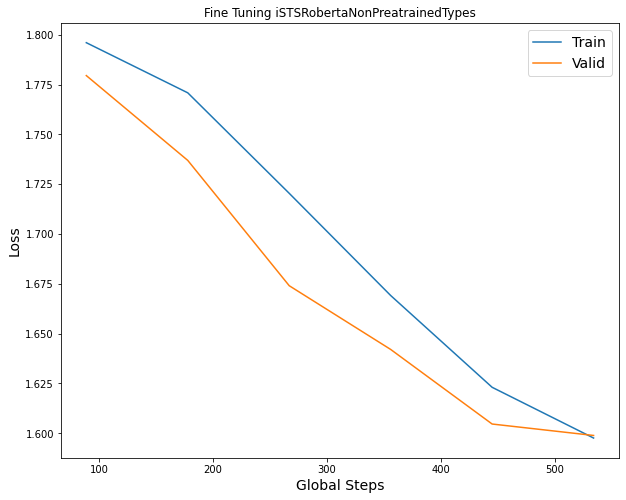

In [ ]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(root + '/'+experiment_name+'_metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Fine Tuning iSTS'+experiment_name)
plt.legend(fontsize=14)
plt.savefig(fname = root + '/'+experiment_name+"pret_fig", format = 'png')
plt.show() 

In [ ]:
def classification_report_csv(report, path):
    report_data = []
    lines = report.split('\n')
    
    with open(path, 'w') as f:
      for line in lines:
          f.write(line)
          f.write('\n')



In [ ]:
# Evaluation Function
def evaluate(model, testing_loader, eval_dataset_name = None):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
                                        
      for  _,vdata in tqdm(enumerate(testing_loader, 0)):
          vids = vdata['ids'].to(device, dtype = torch.long)
          vmask = vdata['mask'].to(device, dtype = torch.long)
          vtoken_type_ids = vdata['token_type_ids'].to(device, dtype = torch.long)
          vtargets = vdata['targets'].to(device, dtype = torch.long)

          voutputs = model(vids, vmask, vtoken_type_ids)

          y_pred.extend(torch.argmax(voutputs, axis=-1).tolist())
          y_true.extend(vtargets.tolist())
    
    
    print('Classification Report:')
    report = classification_report(y_true, y_pred, labels=list(range(num_outputs)), digits=4)
    print(report)
    classification_report_csv(report, path = root + '/'+experiment_name+"_"+eval_dataset_name+"_report.txt")

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_outputs)))
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    plt.savefig(fname = root + '/'+experiment_name+"_cm_"+eval_dataset_name, format = 'png')
        
    my_array = np.array([y_pred,y_true])
    df = pd.DataFrame(my_array)
    return df.T



In [ ]:
df_test_headlines = pd.read_csv(semeval2_root+'test_headlines.csv', header= 0)
df_test_imgs = pd.read_csv(semeval2_root+'test_images.csv', header= 0)
df_test_as = pd.read_csv(semeval2_root+'test_answers-students.csv', header= 0)

df_test_headlines = preprocess_semeval(df_test_headlines, is_score_based=is_score_based)
df_test_imgs = preprocess_semeval(df_test_imgs, is_score_based=is_score_based)
df_test_as = preprocess_semeval(df_test_as, is_score_based=is_score_based)


In [ ]:
test_size = df_test_headlines.shape[0] + df_test_imgs.shape[0] + df_test_as.shape[0] 
train_size = df_train.shape[0] 
valid_size =  df_valid.shape[0]

ds_size = test_size + train_size + valid_size

print(ds_size)
print(train_size)
print(train_size)
print(valid_size)
print(test_size)



10048
5663
5663
1416
2969


In [ ]:
MAX_LEN = 256

df_test_headlines = df_test_headlines.reset_index(drop=True)
df_test_imgs = df_test_imgs.reset_index(drop=True)
df_test_as = df_test_as.reset_index(drop=True)


test_headlines_set = Data(df_test_headlines, tokenizer, MAX_LEN)
test_imgs_set = Data(df_test_imgs, tokenizer, MAX_LEN)
test_as_set = Data(df_test_as, tokenizer, MAX_LEN)

In [ ]:
df_test_imgs.head()

,chunk1,chunk2,value,explanation,type,text,target
0,on the tracks,on tracks,5,EQUI,0,on the tracks . on tracks,0
1,Two green and white trains,Two green and white trains,5,EQUI,0,Two green and white trains . Two green and whi...,0
2,in a street,street,5,EQUI,0,in a street . street,0
3,driving,driving down,4,SPE2,3,driving . driving down,3
4,a bus,Red double decker bus,3,SPE2,3,a bus . Red double decker bus,3


In [ ]:
test_params = {'batch_size': 16,
                'shuffle': True,
                'num_workers': 0
                }

headlines_loader = DataLoader(test_headlines_set, **train_params)
imgs_loader = DataLoader(test_imgs_set, **train_params)
as_loader = DataLoader(test_as_set, **train_params)



Ewaulacja Headlines

18it [00:03,  4.96it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.8889    0.8916    0.8902       664
           1     0.5000    0.5267    0.5130       150
           2     0.2083    0.1531    0.1765        98
           3     0.3433    0.2150    0.2644       107
           4     0.3390    0.6061    0.4348        66
           5     0.4286    0.6000    0.5000        10

    accuracy                         0.6895      1095
   macro avg     0.4513    0.4987    0.4631      1095
weighted avg     0.6840    0.6895    0.6825      1095



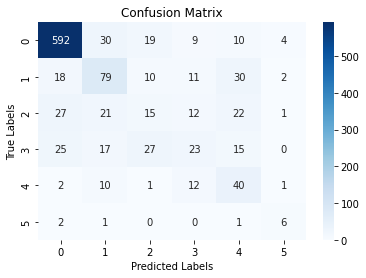

In [ ]:
result_headlines = evaluate(model, headlines_loader, eval_dataset_name ='headlines')


0it [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
15it [00:03,  4.76it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.8884    0.8778    0.8831       499
           1     0.5821    0.4588    0.5132       170
           2     0.4056    0.4603    0.4312       126
           3     0.3462    0.4954    0.4075       109
           4     0.3636    0.1143    0.1739        35
           5     0.4000    0.6667    0.5000         3

    accuracy                         0.6730       942
   macro avg     0.4977    0.5122    0.4848       942
weighted avg     0.6848    0.6730    0.6733       942



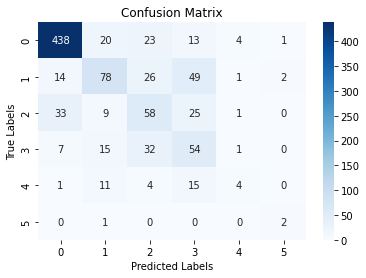

In [ ]:
result_imgs = evaluate(model, imgs_loader, eval_dataset_name ='images')

0it [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
15it [00:03,  4.86it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.9129    0.7801    0.8413       564
           1     0.6571    0.2987    0.4107        77
           2     0.3231    0.3134    0.3182        67
           3     0.5125    0.5256    0.5190        78
           4     0.6500    0.8041    0.7189        97
           5     0.3200    0.9796    0.4824        49

    accuracy                         0.6985       932
   macro avg     0.5626    0.6169    0.5484       932
weighted avg     0.7573    0.6985    0.7095       932



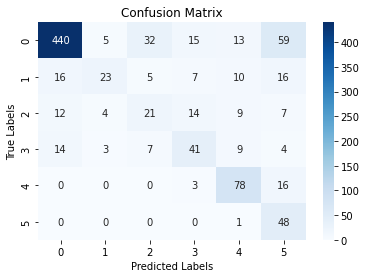

In [ ]:
result_as = evaluate(model, as_loader, eval_dataset_name ='answer_students')

In [ ]:
result_headlines.to_csv(root+ '/'+experiment_name+" headlines.csv", index = False)
result_imgs.to_csv(root+ '/'+experiment_name+" imgs.csv", index = False)
result_as.to_csv(root+ '/'+experiment_name+" as.csv", index = False)